In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Enhanced ResNet18 with PGD through ImageNet100
This is the enhanced version of the ImageNet10 code to create at least 70% accuracy of the ResNet18 model based on the ImageNet100 dataset. There will be PGD attacks performed on it as well. 

# Loading the dataset with labels

Random Validation Images:


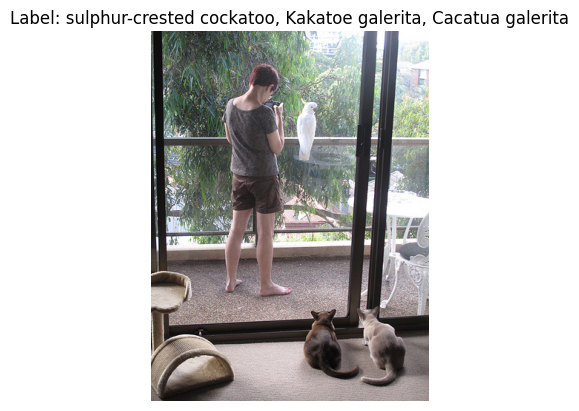

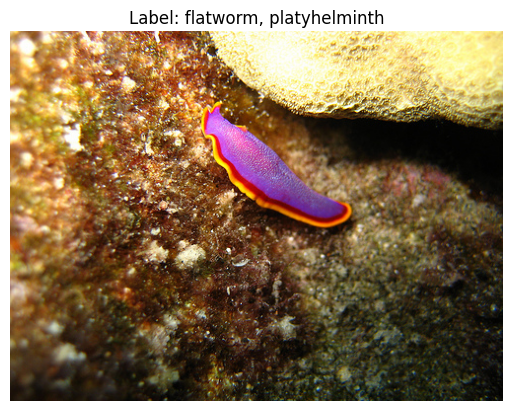

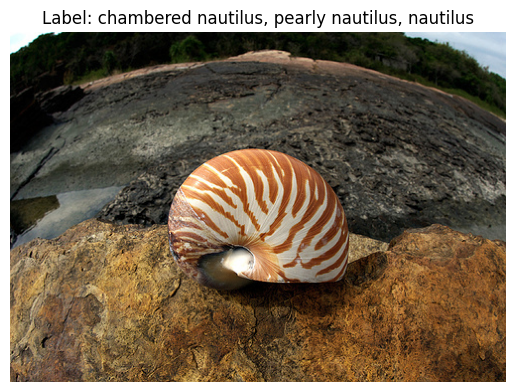

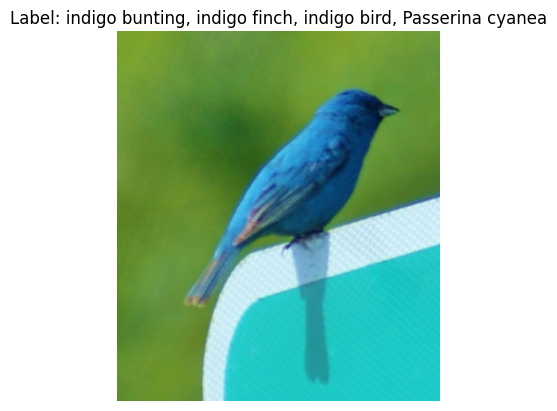

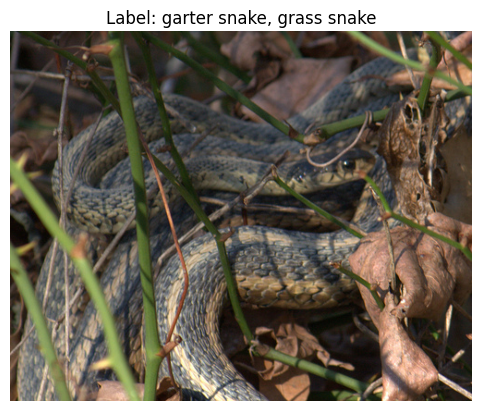

Random Training Images:


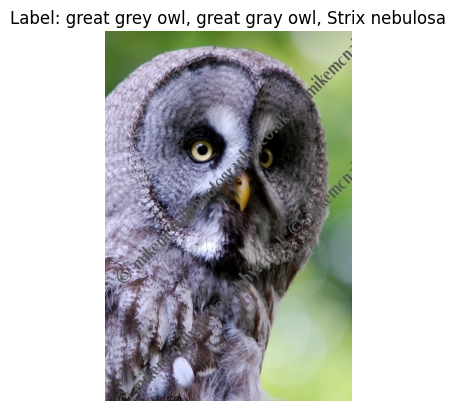

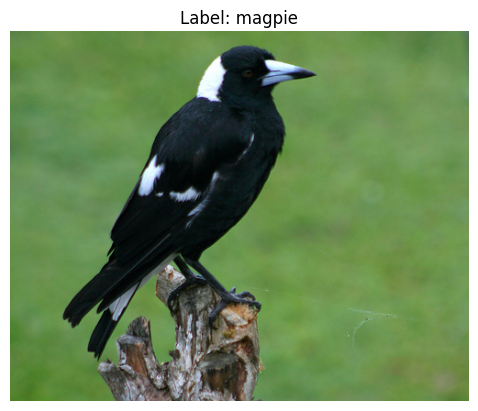

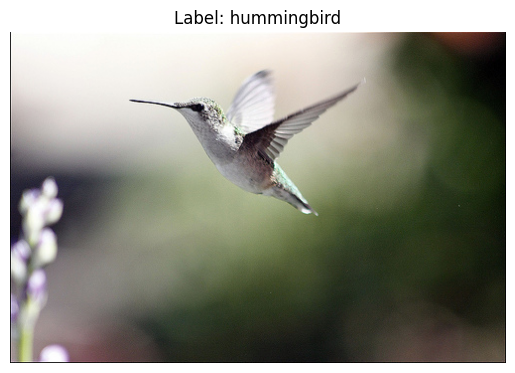

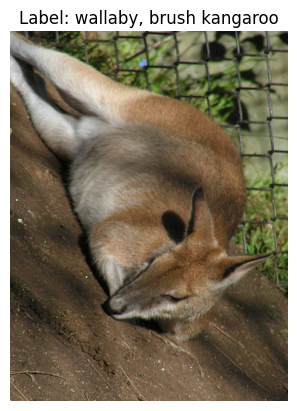

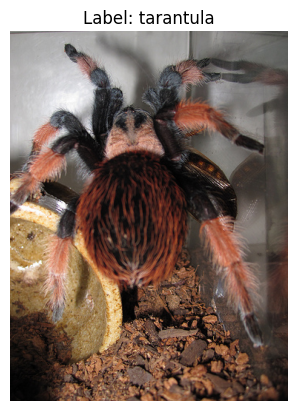

In [5]:
import json
import os
import random
import matplotlib.pyplot as plt
import cv2

# Load labels from JSON file
with open('/kaggle/input/imagenet100/Labels.json', 'r') as f:
    labels = json.load(f)

# Create a mapping from class ID to class name
id_to_class = {str(k): v for k, v in labels.items()}

# Function to display an image with its label
def show_image_with_label(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Directories containing the images
base_train_dir = '/kaggle/input/imagenet100'
val_dir = os.path.join(base_train_dir, 'val.X')
train_dirs = [os.path.join(base_train_dir, f'train.X{i}') for i in range(1, 5)]

# Helper function to get a random sample of images from a directory
def get_random_images(data_dirs, num_samples=5):
    images = []
    all_files = []
    for data_dir in data_dirs:
        for label_id in os.listdir(data_dir):
            class_name = id_to_class.get(label_id, 'Unknown')
            files = os.listdir(os.path.join(data_dir, label_id))
            all_files.extend([(os.path.join(data_dir, label_id, filename), class_name) for filename in files])

    selected_files = random.sample(all_files, num_samples)
    for image_path, class_name in selected_files:
        images.append((image_path, class_name))
    return images

# Get random images from validation set
val_images = get_random_images([val_dir], 5)

# Get random images from all training directories
train_images = get_random_images(train_dirs, 5)

# Display random validation images
print("Random Validation Images:")
for image_path, label in val_images:
    show_image_with_label(image_path, label)

# Display random training images
print("Random Training Images:")
for image_path, label in train_images:
    show_image_with_label(image_path, label)

# Organize Data into Validation and Training Sets

In [6]:
# Creating the transforms
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [7]:
# Create a custom dataset class
class MultiFolderDataset(Dataset):
    def __init__(self, folders, transform=None):
        self.samples = []
        self.transform = transform
        for folder in folders:
            for label_id in os.listdir(folder):
                class_name = id_to_class.get(label_id, 'Unknown')
                files = os.listdir(os.path.join(folder, label_id))
                self.samples.extend([(os.path.join(folder, label_id, filename), label_id) for filename in files])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted(id_to_class.keys()))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = self.class_to_idx[label]
        return image, label

In [8]:
import torchvision.datasets as datasets
# Creating the Datasets
train_dataset = MultiFolderDataset(train_dirs, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Model Training Configuration
* Define Hyperparameters
* Set up DataLoaders

In [9]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training the Model
* Train model with hyperparameters
* Tune hyperparameters systematically
* Fine-tune the model

In [10]:
# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [11]:
from torchvision import models

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 100)
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s] 


In [12]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = torch.nn.Linear(model.fc.in_features, 100)
model = model.to(device)

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Ensure CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import time module to measure time taken for each epoch
import time
from tqdm import tqdm

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    # Training phase
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item() * inputs.size(0)  # Update running loss
        
        if i % 100 == 0:  # Print every 100 batches
            print(f"Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    epoch_loss = running_loss / len(train_loader.dataset)  # Compute epoch loss
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct1 = 0
    correct5 = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            
            val_loss += loss.item() * inputs.size(0)  # Update validation loss
            
            # Calculate accuracy
            _, pred1 = outputs.topk(1, 1, True, True)
            _, pred5 = outputs.topk(5, 1, True, True)
            correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
            correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
            total += labels.size(0)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)  # Compute epoch validation loss
    top1_acc = correct1 / total  # Compute top-1 accuracy
    top5_acc = correct5 / total  # Compute top-5 accuracy
    
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    print(f'Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_duration:.2f}s')
    print(f'Train Loss: {epoch_loss:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}')
    print(f'Top-1 Accuracy: {top1_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}')

print('Training complete')

In [15]:
# Saving the model
torch.save(model.state_dict(), 'ResNet18-ImageNet.pth')

## FGSM Attacks

In [13]:
import torchattacks
from tqdm import tqdm

# Initialize FGSM attack
epsilon = 0.3  # Adjust epsilon as needed
fgsm = torchattacks.FGSM(model, eps=epsilon)

# Evaluate the model on adversarial examples
def evaluate_fgsm_attack(loader, attack, device):
    correct1 = 0
    correct5 = 0
    total = 0

    # Progress bar
    for inputs, labels in tqdm(loader, desc="FGSM Attack Evaluation"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate adversarial examples
        adv_inputs = attack(inputs, labels)

        # Get model predictions
        outputs = model(adv_inputs)
        _, pred1 = outputs.topk(1, 1, True, True)
        _, pred5 = outputs.topk(5, 1, True, True)

        # Update accuracy metrics
        correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
        correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
        total += labels.size(0)

    # Calculate final metrics
    top1_acc = correct1 / total
    top5_acc = correct5 / total

    return top1_acc, top5_acc

# Perform the attack and evaluate
top1_acc, top5_acc = evaluate_fgsm_attack(val_loader, fgsm, device)

print(f"FGSM Attack Results (Epsilon={epsilon}):")
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")


FGSM Attack Evaluation: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s]

FGSM Attack Results (Epsilon=0.3):
Top-1 Accuracy: 0.0456
Top-5 Accuracy: 0.1376


# Implementing and evaluate PGD attacks

In [13]:
pip install torchattacks

Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch.nn as nn

model_path = '/kaggle/input/resnet18-imagenet100/pytorch/default/1/ResNet18-ImageNet.pth'  # Path to the model
checkpoint = torch.load(model_path, map_location=device)  # Use 'cpu' if not using GPU

model.load_state_dict(checkpoint)  # Load the state dictionary


<All keys matched successfully>

In [18]:
from tqdm import tqdm
import torchattacks 
# PGD Attack
pgd_attack = torchattacks.PGD(model, eps=0.001, alpha=2/255, steps=40)

# Function to test adversarial accuracy
def adversarial_test(attack, loader, attack_name):
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc=f"Adversarial Test ({attack_name})"):
        inputs, labels = inputs.to(device), labels.to(device)
        adv_inputs = attack(inputs, labels)
        outputs = model(adv_inputs)
        
        _, pred = outputs.max(1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
    
    acc = correct / total
    print(f'{attack_name} Accuracy: {acc:.4f}')
    return acc

# Evaluate model with PGD attack
pgd_acc = adversarial_test(pgd_attack, val_loader, "PGD")

Adversarial Test (PGD): 100%|██████████| 157/157 [07:51<00:00,  3.00s/it]

PGD Accuracy: 0.1756


# Implementing and evaluate CW attacks

In [52]:
import torchattacks
from tqdm import tqdm

# Initialize Carlini-Wagner attack with fewer steps for quicker evaluation
cw = torchattacks.CW(model, c=15, kappa=10, steps=500, lr=0.05)  # Reduced steps for speed

def evaluate_under_attack(loader, model, attack):
    model.eval()
    correct = 0
    total = 0
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc="Evaluating CW Attack")
    
    for i, (inputs, labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Generate adversarial examples
        adv_inputs = attack(inputs, labels)
        
        # Get model predictions on adversarial examples
        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar with batch accuracy
        progress_bar.set_postfix(batch_accuracy=(correct / total))
    
    accuracy = correct / total
    return accuracy

# Evaluate the model under CW attack
adv_accuracy_cw = evaluate_under_attack(val_loader, model, cw)
print(f'Adversarial Accuracy under CW Attack: {adv_accuracy_cw * 100:.2f}%')

Evaluating CW Attack: 100%|██████████| 157/157 [19:50<00:00,  7.59s/it, batch_accuracy=0.001]   

Adversarial Accuracy under CW Attack: 0.10%


In [22]:
import torchattacks
from tqdm import tqdm

# Set up CW Attack for the AlexNet model on ImageNet100
cw_attack = torchattacks.CW(model, c=1e-3, kappa=0, steps=100, lr=0.01)

# Function to evaluate adversarial accuracy using CW attack
def adversarial_test(attack, loader, attack_name):
    model.eval()  # Ensure the model is in eval mode
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc=f"Adversarial Test ({attack_name})"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Generate adversarial examples
        adv_inputs = attack(inputs, labels)
        
        # Forward pass on adversarial images
        outputs = model(adv_inputs)
        _, predicted = outputs.max(1)
        
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    acc = correct / total
    print(f'{attack_name} Accuracy: {acc:.4f}')
    return acc

# Run CW attack evaluation on validation set
cw_acc = adversarial_test(cw_attack, val_loader, "CW")
print(f'Accuracy under CW Attack: {cw_acc * 100:.2f}%')

Adversarial Test (CW): 100%|██████████| 157/157 [04:10<00:00,  1.60s/it]

CW Accuracy: 0.0814
Accuracy under CW Attack: 8.14%
